In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np
from collections import defaultdict
import math
import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
from trvaep.utils import train_test_split

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [27]:
#loads 
import numpy as np
import torch
import torch.nn as nn

#from .helper_module import Encoder, Decoder

import torch
import torch.nn as nn

from trvaep.utils import one_hot_encoder


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)

                
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, num_classes=None):
        super().__init__()
        self.n_classes = num_classes
        if num_classes is not None:
            layer_sizes[0] += num_classes
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.FC.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
            if use_bn:
                self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
            self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
            if use_dr:
                self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))

        self.linear_means = nn.Linear(layer_sizes[-1], latent_dim)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_dim)

    def forward(self, x, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            x = torch.cat((x, c), dim=-1)
        x = self.FC(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, use_mmd=False, num_classes=None, output_active="ReLU"):
        super().__init__()
        self.use_mmd = use_mmd
        self.op_activation = output_active
        self.use_bn = use_bn
        self.use_dr = use_dr
        if num_classes is not None:
            self.n_classes = num_classes
            input_size = latent_dim + num_classes
        else:
            input_size = latent_dim
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            if i + 1 < len(layer_sizes):
                self.FC.add_module(
                    name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
                if self.use_bn:
                    self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
                self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
                if self.use_dr:
                    self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))
            else:
                if self.op_activation == "ReLU":
                    self.FC.add_module(
                        name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
                    self.FC.add_module(name="output", module=nn.ReLU())
                if self.op_activation == "linear":
                    self.FC.add_module(name="output".format(i), module=nn.Linear(in_size, out_size))

    def forward(self, z, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            z = torch.cat((z, c), dim=-1)
        x = self.FC(z)
        if self.use_mmd:
            y = self.FC.L0(z)
            if self.use_bn:
                y = self.FC.B0(y)
            y = self.FC.A0(y)
            if self.use_dr:
                y = self.FC.D0(y)
            return x, y
        return x


class CVAE(nn.Module):
    """
            CVAE class. This class contains the implementation Conditional
            Variational Auto-encoder.
            # Parameters

                input_dim: integer
                    Number of input features (i.e. gene in case of scRNA-seq).
                num_classes: integer
                    Number of classes (conditions) the data contain. if `None` the model
                    will be a normal VAE instead of conditional VAE.
                encoder_layer_sizes: List
                    A list of hidden layer sizes for encoder network.
                latent_dim: integer
                    Bottleneck layer (z)  size.
                decoder_layer_sizes: List
                    A list of hidden layer sizes for decoder network.
                alpha: float
                     alpha coefficient for KL loss.
                use_batch_norm: boolean
                    if `True` batch normalization will applied to hidden layers
                dr_rate: float
                    Dropput rate applied to hidden layer, if `dr_rate`==0 no dropput will be applied.
                use_mmd: boolean
                    if `True` then MMD will be applied to first decoder layer.
                beta: float
                    beta coefficient for MMD loss.

        """

    def __init__(self, input_dim, output_dim, num_classes=None, encoder_layer_sizes=[64, 32],
                 latent_dim=10, decoder_layer_sizes=[32, 64], alpha=0.001, use_batch_norm=True,
                 dr_rate=0.2, use_mmd=True, beta=1, output_activation="ReLU"):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_dim) == int
        assert type(decoder_layer_sizes) == list
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_cls = num_classes
        self.use_mmd = use_mmd
        self.beta = beta
        self.dr_rate = dr_rate
        if self.dr_rate > 0:
            self.use_dr = True
        else:
            self.use_dr = False
        self.use_bn = use_batch_norm
        self.alpha = alpha
        self.op_activation = output_activation
        encoder_layer_sizes.insert(0, self.input_dim)#math.floor(self.input_dim / 2)) #self.input_dim)
        print('encoder_layer_sizes',encoder_layer_sizes)
        decoder_layer_sizes.append(self.output_dim)
        self.encoder = Encoder(encoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.num_cls)
        self.decoder = Decoder(decoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.use_mmd, self.num_cls, self.op_activation)

    def inference(self, n=1, c=None):
        """
                Generate `n` datapoints by sampling from a standard Gaussian and feeding them
                  to decoder.

                # Parameters
                    n: integer
                    c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                # Returns
                    rec_data: 'numpy nd-array'
                        Returns 'numpy nd-array` containing reconstructed 'data' in shape [n, input_dim].
                """
        batch_size = n
        z = torch.randn([batch_size, self.latent_dim])
        if c is not None:
            c = torch.tensor(c)
        recon_x = self.decoder(z, c)
        return recon_x

    def sampling(self, mu, log_var):
        """
               Samples from standard Normal distribution with shape and
               applies reparametrization trick.
               # Parameters
                   mu: `Tensor`
                        mean vector
                   log_var: `Tensor`
                        log_var tensor
               # Returns
                   The computed Tensor of samples.
           """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)

    def get_latent(self, x, c=None, mean=False):
        """
                  Map `x` in to the latent space. This function will feed data
                  in encoder  and return  z for each sample in data.
                  # Parameters
                      x:  numpy nd-array
                          Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                      c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                      mean: boolean
                           if `True` only return mean vector ohterwise z will be fed to sampling function.
                  # Returns
                      latent: `numpy nd-array`
                          Returns array containing latent space encoding of 'x'
              """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        if mean:
            return z_mean.cpu().data.numpy()
        return z_sample.cpu().data.numpy()

    def get_y(self, x, c=None):
        """
                       Map `x` in to the y dimension as described here https://arxiv.org/abs/1910.01791.
                        This function will feed data in encoder  and return  z for each sample in data.
                       # Parameters
                           x:  numpy nd-array
                               Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                           c: `numpy nd-array`
                             `numpy nd-array` of original desired labels for each sample.
                           mean: boolean
                                if `True` only return mean vector ohterwise z will be fed to sampling function.
                       # Returns
                           latent: `numpy nd-array`
                               Returns array containing latent space encoding of 'x'
                   """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        _, y = self.decoder(z_sample, c)
        return y.cpu().data.numpy()

    def predict(self, x, y, target):
        """
                Predicts how data points `x` with original condition (classes) `y` will look like in `target` condition.
                # Parameters
                    x: `numpy nd-array`
                        nummpy data matrix containing source data points.
                    y: `numpy nd-array`
                        `numpy nd-array` of original labels .
                    target: str
                        target condition for the predcition.
                # Returns
                    output: `numpy nd-array`
                        `numpy nd-array`  of predicted cells in target condition.
                # Example
                ```python
                adata = sc.read("./data/kang_seurat.h5ad")
                sc.pp.normalize_per_cell(adata)
                sc.pp.log1p(adata)
                sc.pp.highly_variable_genes(adata, n_top_genes=1000)
                adata = adata[:, adata.var['highly_variable']]
                n_conditions = adata.obs["condition"].unique().shape[0]
                adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                      & (adata.obs["condition"] == "CTRL"))]
                model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                             encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                             use_mmd=True, beta=10)
                trainer = Trainer(model, adata_train)
                trainer.train_trvae(100, 64)
                data = model.get_y(adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
                adata_latent = sc.AnnData(adata_train)
                adata_latent.obs["cell_type"] = adata_train.obs["cell_type"].tolist()
                adata_latent.obs["condition"] = adata_train.obs["condition"].tolist()
                sc.pp.neighbors(adata_latent)
                sc.tl.umap(adata_latent)
                sc.pl.umap(adata_latent, color=["condition", "cell_type"])
                ground_truth = adata_source = adata[(adata.obs["cell_type"] == "pDC")]
                adata_source = adata[(adata.obs["cell_type"] == "pDC") & (adata.obs["condition"] == "CTRL")]
                predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                                               target="STIM")
                ```
        """

        y = self.label_encoder.transform(np.array(y))
        z = self.get_latent(x, y)
        target_labels = np.array([target])
        target_labels = self.label_encoder.transform(np.tile(target_labels, len(y)))
        predicted = self.reconstruct(z, target_labels, use_latent=True)
        return predicted

    def reconstruct(self, x, c=None, use_latent=False):
        """
        Reconstruct the latent space encoding via the decoder.
        # Parameters
            x: `numpy nd-array`
                nummpy data matrix containing data points.
            c: `numpy nd-array`
                `numpy nd-array` of original labels. Only set in `None` for VAE
                model.
            use_latent: bool
                This flag determines whether the `x` is already in latent space or not.
                if `True`: The `x` is in latent space `x` is in shape [n_obs, latent_dim]).
                if `False`: The `x` is not in latent space (`data.X` is in shape [n_obs, input_dim]).
        # Returns
            rec_data: 'numpy nd-array'
                Returns 'numpy nd-array` containing reconstructed 'data' in shape [n_obs, input_dim].
        """
        if use_latent:
            x = torch.tensor(x).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(x, c)
            else:
                reconstructed = self.decoder(x, c)
            return reconstructed.cpu().data.numpy()
        else:
            z = self.get_latent(x, c)
            z = torch.tensor(z).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(z, c)
                return reconstructed
            else:
                reconstructed = self.decoder(z, c)
                return reconstructed.cpu().data.numpy()

    def forward(self, x, c=None):
        z_mean, z_log_var = self.encoder(x, c)
        z = self.sampling(z_mean, z_log_var)
        if self.use_mmd:
            recon_x, y = self.decoder(z, c)
            return recon_x, z_mean, z_log_var, y
        else:
            recon_x = self.decoder(z, c)
            return recon_x, z_mean, z_log_var


In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [6]:
# creline = get_cre_status(data_info, msvds)
# experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
# leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# # contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# # ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key)
# thres_ncomp = np.asarray([[1e-10,0]])
# wt_2ormore = get_wt_inds(creline)

#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)


In [19]:
an = anndata.AnnData(msvds[sid].reg_inj_vcount_norm)
an.obs= pd.DataFrame(creline[sid])
n_conditions= an.obs[0].unique().shape[0]
condition_key =0

In [23]:
model = CVAE(40,577, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)

encoder_layer_sizes [40, 64, 32]


In [24]:
trainer = trvaep.Trainer(model, an, condition_key=condition_key)

In [25]:
trainer.train_trvae(n_epochs=2, batch_size=100, early_patience=50)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/trvaep/model/_losses.py:8: UserWarning: Using a target size (torch.Size([70, 40])) that is different to the input size (torch.Size([70, 577])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(recon_x, x, reduction="sum")


RuntimeError: The size of tensor a (577) must match the size of tensor b (40) at non-singleton dimension 1

In [16]:
#msvds[sid].reg_proj_vcount_norm.shape

(83, 577)

In [13]:

#trainer = trvaep.Trainer(model, an, condition_key=condition_key)

In [28]:
        n_epochs=2
        batch_size=100
        early_patience=50

        trainer.n_workers=0
    
        self = trainer
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        

In [ ]:
dataset_train.adata

In [46]:
        for epoch in range(n_epochs):
            print('epoch', epoch)
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                print(iteration,x.shape,y.shape, 'iteration')
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y)

epoch 0
0 torch.Size([70, 40]) torch.Size([70, 1]) iteration
epoch 1
0 torch.Size([70, 40]) torch.Size([70, 1]) iteration


In [35]:
recon_x.shape

torch.Size([70, 577])

In [38]:
x.shape

torch.Size([70, 40])

In [39]:
data_loader_train.

In [36]:
vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)

RuntimeError: The size of tensor a (577) must match the size of tensor b (40) at non-singleton dimension 1

In [37]:
x.shape

torch.Size([70, 40])

In [53]:
import numpy as np
import torch
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

from trvaep.utils import remove_sparsity


def label_encoder(adata, label_encoder=None, condition_key='condition'):
    if label_encoder is None:
        le = LabelEncoder()
        labels = le.fit_transform(adata.obs[condition_key].tolist())
    else:
        le = label_encoder
        labels = np.zeros(adata.shape[0])
        for condition, label in label_encoder.items():
            labels[adata.obs[condition_key] == condition] = label
    return labels.reshape(-1, 1), le


class CustomDatasetFromAdata(Dataset):
    def __init__(self, adata, condition_key=None):
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        single_cell_expression = self.data[index, :]
        cell_as_tensor = torch.Tensor(single_cell_expression)
        if self.condtion_key is not None:
            return cell_as_tensor, label_as_tensor
        else:
            return cell_as_tensor, None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le


In [143]:
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split

def train_test_split(adata, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]
    train_data.Y = adata.Y[train_idx, :]
    valid_data.Y = adata.Y[test_idx, :]
    return train_data, valid_data


class CustomDatasetFromAdataRegression(Dataset):
    
    def __init__(self, adata, condition_key=None):
        print(adata.Y.shape)
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        self.Y = np.array(self.adata.Y)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        injection = self.data[index, :]
        projection = self.Y[index,:]
        cell_as_tensor = torch.Tensor(injection)
        if self.condtion_key is not None:
            return injection, projection, label
        else:
            return injection, projection, None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le

    
class Trainer:
    def __init__(self, model, adata,
                 condition_key="condition", seed=0, print_every=2000,
                 learning_rate=0.001, validation_itr=20, train_frac=0.85, n_workers=0):
        """
                trVAE Network class. This class contains the implementation of Regularized Conditional
                Variational Auto-encoder network.
                # Parameters
                    model: CVAE
                        a CVAE model object.
                    adata: `~anndata.AnnData`
                    `AnnData` object for training the model.

                    condition_key: str
                       The observation key in which data conditions are stored
                    seed: integer
                        Random seed for training initialization.

                    print_every= integer
                        How often print the loss values after, by default after every 1000 iterations.

                    learning_rate: float
                        Learning rate for the optimizer.

                    validation_itr: integer
                        How often print validation error, by default after every 5 epochs.

                    train_frac= float
                        Train-test split fraction. the model will be trained with train_frac for training
                        and 1-train_frac for validation.
                    n_workers= int
                        num of subsprocess for loading more batches for GPU. value bigger than 1 will require
                        more RAM and may increase the speed.


            """

        self.model = model
        self.adata = adata
        self.condition_key = condition_key
        self.seed = seed
        self.print_loss = print_every
        self.lr = learning_rate
        self.val_check = validation_itr
        self.train_frac = train_frac
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.device = self.device
        self.logs = defaultdict(list)
        self.model.to(self.device)
        self.n_workers = n_workers

    def make_dataset(self):
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        return data_set_train, data_set_valid

    def train_trvae(self, n_epochs=300, batch_size=512, early_patience=50):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train_trvae(100, 64)
                    ```
        """
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y)
                vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                mmd_calculator = mmd(self.model.num_cls, self.model.beta)
                mdd_loss = mmd_calculator(y_mmd, y)
                loss = vae_loss + mdd_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                train_mmd += mdd_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, "
                          "rec_loss: {:9.4f}, KL_loss: {:9.4f}, MMD_loss:  {:9.4f}".format(
                        epoch, n_epochs, iteration, len(data_loader_train) - 1,
                        loss.item(), reconstruction_loss.item(), kl_loss.item(), mdd_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            self.logs["mmd_loss_train"].append(train_mmd / iteration)
            valid_loss, valid_rec, valid_kl, valid_mmd = self.validate(data_loader_valid, use_mmd=True)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)
            self.logs["MMD_loss_valid"].append(valid_mmd)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f},"
                      " KL_loss_valid: {:9.4f}, MMD_loss:  {:9.4f} ".format(
                    epoch, valid_loss, valid_rec, valid_kl, valid_mmd))
        self.model.eval()

    def train(self, n_epochs=100, batch_size=256, early_patience=15):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train(100, 64)
                    ```
        """

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
                    epoch, valid_loss, valid_rec, valid_kl))
        self.model.eval()

    def validate(self, validation_data, use_mmd=False):
        """
                            Validat a CVAE model using  `validation_data`.
                            # Parameters
                                validation_data: `~anndata.AnnData`
                                    `AnnData` object for validating the model.
                                use_mmd: boolean
                                    If `True` the mmd loss wil be returned
                            # Returns
                                if `use_mmd` is `True` return following four `float`

                                valid_loss: float
                                    sum of all the losses

                                valid_rec: float
                                    reconstruction loss for the validation data

                                valid_kl: float
                                    KL loss for the validation data

                                valid_mmd: float
                                    MMD loss for validation data

                """
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0
            valid_rec = 0
            valid_kl = 0
            valid_mmd = 0
            for iteration, (x, y) in enumerate(validation_data):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    if self.model.use_mmd:
                        recon_x, mean, log_var, y_mmd = self.model(x, y)
                    else:
                        recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                valid_vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                if self.model.use_mmd:
                    mms_calculator = mmd(self.model.num_cls, 10)
                    valid_mmd = mms_calculator(y_mmd, y)
                if use_mmd:
                    valid_loss += valid_vae_loss.item() + valid_mmd.item()
                else:
                    valid_loss += valid_vae_loss.item()
                valid_rec += reconstruction_loss.item()
                valid_kl += kl_loss.item()
                if use_mmd:
                    valid_mmd += valid_mmd.item()
        self.model.train()
        if iteration < 1:
            iteration = 1
        if use_mmd:
                return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration, valid_mmd / iteration
        else:
            return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)


In [144]:
an = anndata.AnnData(msvds[sid].reg_inj_vcount_norm)
an.obs= pd.DataFrame(creline[sid])
n_conditions= an.obs[0].unique().shape[0]
condition_key =0
model = CVAE(40,577, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)
trainer = Trainer(model, an, condition_key=condition_key)
an.Y= msvds[sid].reg_proj_vcount_norm
trainer.adata.Y = msvds[sid].reg_proj_vcount_norm

In [146]:
model = CVAE(40,577, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)
trainer = Trainer(model, an, condition_key=condition_key)

encoder_layer_sizes [40, 64, 32]


In [195]:
an.X.shape

(1128, 43)

In [216]:
        sid = 315
        n_epochs=2
        batch_size=100
        input_dim = 43
        early_patience=50
        an = anndata.AnnData(msvds[sid].reg_inj_vcount_norm)
        an.obs= pd.DataFrame(creline[sid])
        an.Y = torch.tensor(msvds[sid].reg_proj_vcount_norm, dtype = float)
        n_conditions= an.obs[0].unique().shape[0]

        model = CVAE(input_dim,577, num_classes=n_conditions,
                    output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)
        
        trainer = Trainer(model, an, condition_key=condition_key)
        trainer.n_workers=0
        #trainer.Y = msvds[sid].reg_proj_vcount_norm  
        #trainer.adata.Y = msvds[sid].reg_proj_vcount_norm    
        self = trainer
        dataset_train, dataset_valid = self.make_dataset()

encoder_layer_sizes [43, 64, 32]
torch.Size([958, 577])
torch.Size([170, 577])


In [307]:
data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
self.logs = defaultdict(list)
self.model.train()
n_epochs = 100

In [308]:
        for epoch in range(n_epochs):
            print('epoch', epoch)
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                print(iteration, 'iteration')
                if l is not None:
                    x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                else:
                    x = x.to(self.device)#, y = y.to(self.device)
                print(x.shape, y.shape)
                recon_x, mean, log_var, y_mmd = self.model(x, y)
                #print(torch.norm(recon_x - y))
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
#             self.logs['loss_train'].append(train_loss / iteration)
#             self.logs["rec_loss_train"].append(train_rec / iteration)
#             self.logs["KL_loss_train"].append(train_kl / iteration)
#             valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
#             self.logs['loss_valid'].append(valid_loss)
#             self.logs["rec_loss_valid"].append(valid_rec)
#             self.logs["KL_loss_valid"].append(valid_kl)



epoch 0
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0000/9, Loss:    0.0316, rec_loss:    0.0315, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0001/9, Loss:    0.0078, rec_loss:    0.0076, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0002/9, Loss:    0.0053, rec_loss:    0.0051, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0003/9, Loss:    0.0047, rec_loss:    0.0045, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0004/9, Loss:    0.0082, rec_loss:    0.0081, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0005/9, Loss:    0.0062, rec_loss:    0.0061, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 00/100 Batch 0006/9, Loss:    0.0066, rec_loss:    0.0064, KL_loss:    0.0002
7 ite

Epoch 07/100 Batch 0001/9, Loss:    0.0033, rec_loss:    0.0031, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0002/9, Loss:    0.0042, rec_loss:    0.0041, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0003/9, Loss:    0.0028, rec_loss:    0.0026, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0004/9, Loss:    0.0040, rec_loss:    0.0038, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0005/9, Loss:    0.0028, rec_loss:    0.0027, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0006/9, Loss:    0.0024, rec_loss:    0.0023, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 Batch 0007/9, Loss:    0.0299, rec_loss:    0.0298, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 07/100 

Epoch 14/100 Batch 0002/9, Loss:    0.0290, rec_loss:    0.0288, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0003/9, Loss:    0.0021, rec_loss:    0.0019, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0004/9, Loss:    0.0018, rec_loss:    0.0017, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0005/9, Loss:    0.0018, rec_loss:    0.0016, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0006/9, Loss:    0.0013, rec_loss:    0.0012, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0007/9, Loss:    0.0020, rec_loss:    0.0018, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 14/100 Batch 0008/9, Loss:    0.0017, rec_loss:    0.0015, KL_loss:    0.0002
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 14/100 Ba

Epoch 20/100 Batch 0001/9, Loss:    0.0018, rec_loss:    0.0017, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0002/9, Loss:    0.0014, rec_loss:    0.0013, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0003/9, Loss:    0.0016, rec_loss:    0.0014, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0004/9, Loss:    0.0014, rec_loss:    0.0012, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0005/9, Loss:    0.0031, rec_loss:    0.0029, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0006/9, Loss:    0.0027, rec_loss:    0.0026, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 Batch 0007/9, Loss:    0.0296, rec_loss:    0.0294, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 20/100 

0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0000/9, Loss:    0.0021, rec_loss:    0.0020, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0001/9, Loss:    0.0008, rec_loss:    0.0006, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0002/9, Loss:    0.0011, rec_loss:    0.0009, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0003/9, Loss:    0.0023, rec_loss:    0.0021, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0004/9, Loss:    0.0291, rec_loss:    0.0289, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0005/9, Loss:    0.0035, rec_loss:    0.0033, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 26/100 Batch 0006/9, Loss:    0.0017, rec_loss:    0.0015, KL_loss:    0.0002
7 iteration
t

0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0000/9, Loss:    0.0017, rec_loss:    0.0016, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0001/9, Loss:    0.0008, rec_loss:    0.0007, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0002/9, Loss:    0.0015, rec_loss:    0.0013, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0003/9, Loss:    0.0017, rec_loss:    0.0015, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0004/9, Loss:    0.0022, rec_loss:    0.0020, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0005/9, Loss:    0.0010, rec_loss:    0.0008, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 32/100 Batch 0006/9, Loss:    0.0011, rec_loss:    0.0010, KL_loss:    0.0002
7 iteration
t

8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 37/100 Batch 0008/9, Loss:    0.0020, rec_loss:    0.0018, KL_loss:    0.0002
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 37/100 Batch 0009/9, Loss:    0.0007, rec_loss:    0.0006, KL_loss:    0.0002
epoch 38
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 38/100 Batch 0000/9, Loss:    0.0012, rec_loss:    0.0010, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 38/100 Batch 0001/9, Loss:    0.0018, rec_loss:    0.0016, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 38/100 Batch 0002/9, Loss:    0.0008, rec_loss:    0.0006, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 38/100 Batch 0003/9, Loss:    0.0013, rec_loss:    0.0011, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 38/100 Batch 0004/9, Loss:    0.0006, rec_loss:    0.0004, KL_loss:    0.0002
5 iter

7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 43/100 Batch 0007/9, Loss:    0.0006, rec_loss:    0.0005, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 43/100 Batch 0008/9, Loss:    0.0005, rec_loss:    0.0004, KL_loss:    0.0002
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 43/100 Batch 0009/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0002
epoch 44
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 44/100 Batch 0000/9, Loss:    0.0021, rec_loss:    0.0019, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 44/100 Batch 0001/9, Loss:    0.0018, rec_loss:    0.0016, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 44/100 Batch 0002/9, Loss:    0.0006, rec_loss:    0.0005, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 44/100 Batch 0003/9, Loss:    0.0014, rec_loss:    0.0012, KL_loss:    0.0002
4 iter

Epoch 49/100 Batch 0005/9, Loss:    0.0014, rec_loss:    0.0013, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 49/100 Batch 0006/9, Loss:    0.0006, rec_loss:    0.0005, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 49/100 Batch 0007/9, Loss:    0.0005, rec_loss:    0.0004, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 49/100 Batch 0008/9, Loss:    0.0007, rec_loss:    0.0005, KL_loss:    0.0002
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 49/100 Batch 0009/9, Loss:    0.0013, rec_loss:    0.0011, KL_loss:    0.0002
epoch 50
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 50/100 Batch 0000/9, Loss:    0.0006, rec_loss:    0.0004, KL_loss:    0.0002
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 50/100 Batch 0001/9, Loss:    0.0007, rec_loss:    0.0005, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 

Epoch 55/100 Batch 0003/9, Loss:    0.0014, rec_loss:    0.0012, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 55/100 Batch 0004/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 55/100 Batch 0005/9, Loss:    0.0020, rec_loss:    0.0019, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 55/100 Batch 0006/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 55/100 Batch 0007/9, Loss:    0.0004, rec_loss:    0.0003, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 55/100 Batch 0008/9, Loss:    0.0012, rec_loss:    0.0011, KL_loss:    0.0002
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 55/100 Batch 0009/9, Loss:    0.0007, rec_loss:    0.0005, KL_loss:    0.0002
epoch 56
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 

Epoch 61/100 Batch 0001/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0002
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0002/9, Loss:    0.0013, rec_loss:    0.0012, KL_loss:    0.0002
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0003/9, Loss:    0.0005, rec_loss:    0.0004, KL_loss:    0.0002
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0004/9, Loss:    0.0010, rec_loss:    0.0008, KL_loss:    0.0002
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0005/9, Loss:    0.0008, rec_loss:    0.0006, KL_loss:    0.0002
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0006/9, Loss:    0.0018, rec_loss:    0.0016, KL_loss:    0.0002
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 Batch 0007/9, Loss:    0.0017, rec_loss:    0.0015, KL_loss:    0.0002
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 61/100 

Epoch 67/100 Batch 0000/9, Loss:    0.0006, rec_loss:    0.0005, KL_loss:    0.0001
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0001/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0001
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0002/9, Loss:    0.0013, rec_loss:    0.0012, KL_loss:    0.0001
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0003/9, Loss:    0.0004, rec_loss:    0.0002, KL_loss:    0.0001
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0004/9, Loss:    0.0272, rec_loss:    0.0270, KL_loss:    0.0001
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0005/9, Loss:    0.0010, rec_loss:    0.0008, KL_loss:    0.0001
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 Batch 0006/9, Loss:    0.0018, rec_loss:    0.0017, KL_loss:    0.0001
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 67/100 

Epoch 74/100 Batch 0001/9, Loss:    0.0008, rec_loss:    0.0007, KL_loss:    0.0001
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0002/9, Loss:    0.0014, rec_loss:    0.0013, KL_loss:    0.0001
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0003/9, Loss:    0.0013, rec_loss:    0.0011, KL_loss:    0.0001
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0004/9, Loss:    0.0005, rec_loss:    0.0004, KL_loss:    0.0001
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0005/9, Loss:    0.0004, rec_loss:    0.0003, KL_loss:    0.0001
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0006/9, Loss:    0.0004, rec_loss:    0.0002, KL_loss:    0.0001
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 Batch 0007/9, Loss:    0.0285, rec_loss:    0.0284, KL_loss:    0.0001
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 74/100 

Epoch 79/100 Batch 0009/9, Loss:    0.0004, rec_loss:    0.0002, KL_loss:    0.0001
epoch 80
0 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0000/9, Loss:    0.0003, rec_loss:    0.0002, KL_loss:    0.0001
1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0001/9, Loss:    0.0017, rec_loss:    0.0016, KL_loss:    0.0001
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0002/9, Loss:    0.0007, rec_loss:    0.0005, KL_loss:    0.0001
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0003/9, Loss:    0.0012, rec_loss:    0.0010, KL_loss:    0.0001
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0004/9, Loss:    0.0025, rec_loss:    0.0023, KL_loss:    0.0001
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 80/100 Batch 0005/9, Loss:    0.0003, rec_loss:    0.0002, KL_loss:    0.0001
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoc

1 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0001/9, Loss:    0.0029, rec_loss:    0.0027, KL_loss:    0.0001
2 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0002/9, Loss:    0.0005, rec_loss:    0.0003, KL_loss:    0.0001
3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0003/9, Loss:    0.0011, rec_loss:    0.0010, KL_loss:    0.0001
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0004/9, Loss:    0.0270, rec_loss:    0.0269, KL_loss:    0.0001
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0005/9, Loss:    0.0008, rec_loss:    0.0007, KL_loss:    0.0001
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0006/9, Loss:    0.0015, rec_loss:    0.0013, KL_loss:    0.0001
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 87/100 Batch 0007/9, Loss:    0.0007, rec_loss:    0.0006, KL_loss:    0.0001
8 iteration
t

3 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0003/9, Loss:    0.0003, rec_loss:    0.0002, KL_loss:    0.0001
4 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0004/9, Loss:    0.0273, rec_loss:    0.0272, KL_loss:    0.0001
5 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0005/9, Loss:    0.0027, rec_loss:    0.0026, KL_loss:    0.0001
6 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0006/9, Loss:    0.0010, rec_loss:    0.0009, KL_loss:    0.0001
7 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0007/9, Loss:    0.0006, rec_loss:    0.0005, KL_loss:    0.0001
8 iteration
torch.Size([100, 43]) torch.Size([100, 577])
Epoch 94/100 Batch 0008/9, Loss:    0.0003, rec_loss:    0.0002, KL_loss:    0.0001
9 iteration
torch.Size([58, 43]) torch.Size([58, 577])
Epoch 94/100 Batch 0009/9, Loss:    0.0005, rec_loss:    0.0004, KL_loss:    0.0001
epoch 95
0 iter

In [311]:
[np.linalg.norm(recon_x.detach().numpy()[i]- y.detach().numpy()[i]) for i in range(58)]

[0.008693195265472225,
 0.0026841719787148335,
 0.0015554245541034605,
 0.0018475282470141509,
 0.005221515369968766,
 0.008016730506159376,
 0.0029663735593481112,
 0.0007319212933013225,
 0.012162775167480712,
 0.0026233483299047096,
 0.009581276163683188,
 0.007385239917698324,
 0.00544929513672526,
 0.003587984100813053,
 0.01965240678077584,
 0.0050163262057805556,
 0.002623370574865474,
 0.0018935556758562816,
 0.026131953607626667,
 0.00797802534329755,
 0.0004412594698979749,
 0.029155654368857076,
 0.003019172466464994,
 0.0005919485671573527,
 0.001010281611584991,
 0.006005486111773785,
 0.010779058411382011,
 0.0064480434562025225,
 0.016012835587073875,
 0.008685940498994337,
 0.017670774203051923,
 0.007509879781899576,
 0.02511527338844352,
 0.00800070594597807,
 0.004904807222347336,
 0.00509871470436147,
 0.006368242096514247,
 0.009079402467973544,
 0.007843903566402754,
 0.0034185913393841943,
 0.009742957267316598,
 0.017025574513862773,
 0.0221665452644148,
 0.0204

In [387]:
MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                

(tensor(0.0003, grad_fn=<DivBackward0>),
 tensor(0.0002, grad_fn=<DivBackward0>),
 tensor(0.0001, grad_fn=<DivBackward0>))

In [386]:
MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                

(tensor(0.0003, grad_fn=<DivBackward0>),
 tensor(0.0002, grad_fn=<DivBackward0>),
 tensor(0.0001, grad_fn=<DivBackward0>))

In [393]:
((recon_x.detach().float()-  y.detach().float())**2).mean()

tensor(3.0796e-07)

In [394]:
(( y.detach().float())**2).mean()

tensor(1.3623e-07)

In [392]:
torch.nn.functional.mse_loss(recon_x.float()[:,:], y.float()[:,:], reduction="mean") #/ (recon_x.size(0) *recon_x.size(1) ) #not correct, should be

tensor(3.0796e-07, grad_fn=<MseLossBackward>)

In [352]:
help(torch.nn.functional.mse_loss)

Help on function mse_loss in module torch.nn.functional:

mse_loss(input, target, size_average=None, reduce=None, reduction='mean')
    mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor
    
    Measures the element-wise mean squared error.
    
    See :class:`~torch.nn.MSELoss` for details.



In [416]:
                if l is not None:
                    x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                else:
                    x = x.to(self.device)#, y = y.to(self.device)
                print(x.shape, y.shape)
                recon_x, mean, log_var, y_mmd = self.model(x, y)
                #print(torch.norm(recon_x - y))
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 

torch.Size([58, 43]) torch.Size([58, 577])


In [417]:
((recon_x.detach().float() - y.detach().float())**2).mean()

tensor(1.7540e-07)

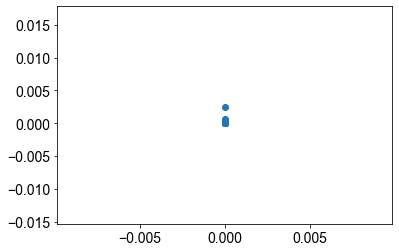

In [420]:
plt.scatter(recon_x.detach().float()[1], y.detach().float()[1])

In [422]:
creline

{512: array(['C57BL/6J', 'Pcp2-Cre_GN135', 'Gad2-IRES-Cre', 'C57BL/6J',
        'Pcp2-Cre_GN135', 'Gabra6-IRES-Cre', 'Htr2a-Cre_KM207',
        'Ppp1r17-Cre_NL146', 'Grm2-Cre_MR90', 'C57BL/6J', 'Gad2-IRES-Cre',
        'C57BL/6J', 'Gpr26-Cre_KO250', 'Gabra6-IRES-Cre', 'Nos1-CreERT2',
        'Pcp2-Cre_GN135', 'Ntsr1-Cre_GN220', 'C57BL/6J', 'Pvalb-IRES-Cre',
        'Pcp2-Cre_GN135', 'Efr3a-Cre_NO108', 'C57BL/6J', 'C57BL/6J',
        'Slc17a6-IRES-Cre', 'C57BL/6J', 'Grik4-Cre', 'Gabra6-IRES-Cre',
        'C57BL/6J', 'Slc17a6-IRES-Cre', 'C57BL/6J', 'C57BL/6J',
        'Ppp1r17-Cre_NL146', 'Scnn1a-Tg3-Cre', 'Grm2-Cre_MR90',
        'Pvalb-IRES-Cre', 'C57BL/6J'], dtype=object),
 703: array(['Cux2-IRES-Cre', 'Rbp4-Cre_KL100', 'Dlg3-Cre_KG118',
        'Gnb4-IRES2-Cre', 'C57BL/6J', 'Gnb4-IRES2-Cre',
        'Ppp1r17-Cre_NL146'], dtype=object),
 1089: array(['C57BL/6J', 'Vipr2-Cre_KE2', 'C57BL/6J', 'Htr2a-Cre_KM207',
        'Grik4-Cre', 'Grp-Cre_KH288', 'Pcdh9-Cre_NP276',
        'Slc17a6-IR

In [421]:
recon_x.detach().float()[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [430]:
sid = 315
creline[sid]
#msvds[]

array(['Rbp4-Cre_KL100', 'Nr5a1-Cre', 'Sim1-Cre_KJ18', ..., 'C57BL/6J',
       'Tlx3-Cre_PL56', 'C57BL/6J'], dtype=object)

In [431]:
cre_subset = np.asarray(['Cux2-IRES-Cre', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
exp_toinclude = np.where(np.isin(creline[sid],cre_subset))[0]
msvds[sid].reg_inj_vcount_norm[exp_toinclude].sum(axis = 0).shape

(43,)

In [439]:
msvds[315].reg_inj_vcount_norm.shape

(1128, 43)

In [437]:
len(np.unique(leafs[sid]))

119

In [423]:
np.unique(creline[sid])

array(['A930038C07Rik-Tg1-Cre', 'C57BL/6J', 'Calb1-T2A-dgCre',
       'Calb2-IRES-Cre', 'Chrna2-Cre_OE25', 'Chrnb4-Cre_OL57',
       'Cort-T2A-Cre', 'Crh-IRES-Cre_BL', 'Ctgf-T2A-dgCre',
       'Cux2-IRES-Cre', 'Drd3-Cre_KI196', 'Efr3a-Cre_NO108',
       'Emx1-IRES-Cre', 'Erbb4-T2A-CreERT2', 'Etv1-CreERT2',
       'Gad2-IRES-Cre', 'Glt25d2-Cre_NF107', 'Gnb4-IRES2-CreERT2',
       'Gng7-Cre_KH71', 'Gpr26-Cre_KO250', 'Grm2-Cre_MR90',
       'Grp-Cre_KH288', 'Htr2a-Cre_KM207', 'Htr3a-Cre_NO152',
       'Nos1-CreERT2', 'Npr3-IRES2-Cre', 'Nr5a1-Cre', 'Ntng2-IRES2-Cre',
       'Ntsr1-Cre_GN220', 'Oxtr-Cre_ON66', 'Oxtr-T2A-Cre',
       'Penk-IRES2-Cre-neo', 'Plxnd1-Cre_OG1', 'Pvalb-IRES-Cre',
       'Pvalb-T2A-CreERT2', 'Rasgrf2-T2A-dCre', 'Rbp4-Cre_KL100',
       'Rorb-IRES2-Cre', 'Rorb-IRES2-Cre-neo', 'Scnn1a-Tg3-Cre',
       'Sepw1-Cre_NP39', 'Sim1-Cre_KJ18', 'Slc17a8-IRES2-Cre',
       'Slc17a8-iCre', 'Slc18a2-Cre_OZ14', 'Sst-IRES-Cre',
       'Syt6-Cre_KI148', 'Tac1-IRES2-Cre', 'Tlx3-Cre_

In [359]:
loss = nn.MSELoss()
ab = torch.randn(3, 5, requires_grad=True)
bc = torch.randn(3, 5)
output = loss(ab, bc)

In [375]:
((ab.detach().numpy() - bc.detach().numpy())**2).mean()

2.0037632

In [364]:
((input-target)**2).mean()

tensor(2.0038, grad_fn=<MseLossBackward>)

In [358]:
np.linalg.norm(y.float()[:,:1] , axis =0) / 58

array([0.00013529], dtype=float32)

In [228]:
torch.nn.functional.mse_loss(recon_x.float(), y.float(), reduction="sum")

tensor(6202.9170, grad_fn=<MseLossBackward>)

In [237]:
help(model.predict)

Help on method predict in module __main__:

predict(x, y, target) method of __main__.CVAE instance
    Predicts how data points `x` with original condition (classes) `y` will look like in `target` condition.
    # Parameters
        x: `numpy nd-array`
            nummpy data matrix containing source data points.
        y: `numpy nd-array`
            `numpy nd-array` of original labels .
        target: str
            target condition for the predcition.
    # Returns
        output: `numpy nd-array`
            `numpy nd-array`  of predicted cells in target condition.
    # Example
    ```python
    adata = sc.read("./data/kang_seurat.h5ad")
    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    adata = adata[:, adata.var['highly_variable']]
    n_conditions = adata.obs["condition"].unique().shape[0]
    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                          & (adata.obs["condition"] == "CTR

In [245]:
target = 'C57BL/6J'

In [250]:
predictions = model.predict(x=trainer.adata.X, y=trainer.adata.obs[0].tolist(), target = target)#, target="Hpoly.Day10")

In [252]:
trainer.adata.Y.shape

torch.Size([1128, 577])

In [274]:
np.linalg.norm(predictions[100] - np.asarray(trainer.adata.Y.numpy()[100]))


0.1315124297383009

array([[3.04119460e-06, 7.35255539e-08, 0.00000000e+00, ...,
        3.55744688e-05, 0.00000000e+00, 6.68961473e-05],
       [2.82289232e-05, 8.90586503e-08, 1.97946352e-07, ...,
        0.00000000e+00, 0.00000000e+00, 5.18357467e-08],
       [3.39250941e-04, 4.05246894e-05, 0.00000000e+00, ...,
        9.55186619e-05, 1.06191508e-05, 4.10004516e-05],
       ...,
       [5.92890110e-06, 7.40930393e-07, 4.57456602e-09, ...,
        1.22227913e-06, 2.23072417e-07, 7.82807826e-07],
       [1.52864616e-04, 4.53580476e-07, 9.19422146e-08, ...,
        2.28660919e-04, 7.16348029e-05, 1.57515913e-04],
       [5.06019229e-05, 1.42365185e-08, 3.57683025e-07, ...,
        1.15502469e-06, 4.42589226e-07, 2.28947992e-06]])

In [265]:
trainer.adata.Y[100]

tensor([1.4042e-05, 1.2407e-08, 6.9688e-07, 0.0000e+00, 2.5034e-05, 3.8845e-04,
        8.0020e-06, 3.7700e-08, 0.0000e+00, 0.0000e+00, 1.5048e-06, 2.8238e-04,
        1.8914e-03, 1.0596e-03, 6.8228e-05, 2.2104e-07, 1.3055e-07, 2.5778e-06,
        0.0000e+00, 1.6965e-07, 2.8361e-06, 5.3712e-06, 1.5155e-08, 5.8456e-07,
        9.5845e-07, 4.1454e-06, 3.8108e-06, 0.0000e+00, 5.5242e-06, 0.0000e+00,
        1.3414e-07, 1.9523e-05, 7.5511e-07, 6.1340e-05, 1.2092e-08, 6.9397e-06,
        5.1437e-10, 5.3519e-08, 8.0922e-07, 0.0000e+00, 0.0000e+00, 6.0578e-06,
        2.1295e-08, 1.7240e-06, 1.3625e-05, 0.0000e+00, 1.8791e-08, 1.9358e-08,
        9.8299e-07, 0.0000e+00, 9.4604e-13, 1.9029e-05, 1.5575e-06, 2.6939e-07,
        1.9964e-05, 1.2554e-05, 0.0000e+00, 3.9996e-09, 1.0279e-09, 1.4573e-06,
        5.6245e-06, 3.5653e-07, 1.1614e-06, 0.0000e+00, 2.7681e-07, 0.0000e+00,
        5.0295e-07, 9.5370e-06, 7.0261e-07, 3.7667e-07, 2.7008e-05, 1.1341e-04,
        0.0000e+00, 1.1737e-05, 0.0000e+

In [148]:
trainer.adata.Y = msvds[sid].reg_proj_vcount_norm

In [149]:

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        

AttributeError: 'AnnData' object has no attribute 'Y'

In [158]:
trainer.adata.Y = msvds[sid].reg_proj_vcount_norm_renorm
self = trainer

train_adata, validation_adata = train_test_split(self.adata, self.train_frac)

data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
self.model.label_encoder = data_set_train.get_label_ecnoder()


(70, 577)
(13, 577)


In [157]:
train_adata.Y

AttributeError: 'AnnData' object has no attribute 'Y'

In [170]:
an = anndata.AnnData(msvds[sid].reg_inj_vcount_norm)#anndata.AnnData(np.hstack([msvds[sid].reg_inj_vcount_norm,msvds[sid].reg_proj_vcount_norm ]))
an.obs= pd.DataFrame(creline[sid])
#an.Y = 
n_conditions= an.obs[0].unique().shape[0]
condition_key =0

In [169]:
model = CVAE(40,577, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)
trainer = Trainer(model, an, condition_key=condition_key)

encoder_layer_sizes [40, 64, 32]
